# REGRESSION USING MULTILAYER PERCEPTRON

In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression

## metrics regression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

import warnings
import importlib
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import IPython
import IPython.display

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

## Metrics
mse_metric = tf.keras.metrics.MeanSquaredError()
mae_metric = tf.keras.metrics.MeanAbsoluteError()

In [4]:
## Dataset
def preprocess(x, y):
    return x, y
    
def make_dataset(feature, y, batch_size=512, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.map(preprocess)
    if is_training:
        ds = ds.shuffle(3*batch_size) #256
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def compute_metric_by_batch(model, ds):
    metrics_res = []
    i = 0
    mse_metric.reset_states()
    mae_metric.reset_states()
    for x_batch, y_batch in iter(ds):        
        y_pred = model.predict_on_batch(x_batch) 
        mse_metric.update_state(y_batch, y_pred)
        mae_metric.update_state(y_batch, y_pred)           
        i += 1            

    return np.round(mse_metric.result().numpy(), 4), np.round(mae_metric.result().numpy(), 4)

def show_curves(history):                 
    df_history = pd.DataFrame(history.history)    
    df_history = df_history.set_index(np.arange(df_history.shape[0]))    
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    df_history[['loss', 'val_loss']].plot(ax=ax[0])
    df_history[['mse', 'val_mse']].plot(ax=ax[1])
    df_history[['mae', 'val_mae']].plot(ax=ax[2])                

def compute_metrics(model, ds):    
    mse, mae = compute_metric_by_batch(model, ds)             
    return {'rmse':np.sqrt(mse), 'mae':mae}    

def define_ffnn_model(input_shape, output_shape, dict_parameters):        
    features_inputs = tf.keras.Input((input_shape), dtype=tf.float16)
    units = dict_parameters['units']
    dropout = dict_parameters['dropout']
    rate_var_units = dict_parameters['rate_var_units']
    rate_var_drop = dict_parameters['rate_var_drop']
    i = 0
    for hidden in range(dict_parameters['hidden']):    
        if i == 0:
            x = layers.Dense(units, kernel_regularizer="l2")(features_inputs)
        else:
            x = layers.Dense(units, kernel_regularizer="l2")(x) 
            
        x = layers.Activation(dict_parameters['activation'])(x)
        #x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)

        units = int(units*rate_var_units)
        dropout = int(dropout*rate_var_drop)
        i += 1

    output = layers.Dense(output_shape, use_bias=False)(x)
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output]) 
    
    return model

def plot_results(y_train, y_train_pred, y_test, y_test_pred, figsize=[20,8]):
    df_result_train_plot = pd.DataFrame(np.vstack([y_train, y_train_pred]).T)
    df_result_train_plot.columns = ['train', 'train_pred']

    df_result_test_plot = pd.DataFrame(np.vstack([y_test, y_test_pred]).T)
    df_result_test_plot.columns = ['test', 'test_pred']
    
    fig, ax = plt.subplots(1, 2) #figsize=[50,16])
    df_result_train_plot.plot(style='.', figsize=figsize, ax=ax[0])
    df_result_test_plot.plot(style='.-', figsize=figsize, ax=ax[1])

def get_predictions(ds):
    list_y = []
    list_y_pred = []
    for x_batch, y_batch in iter(ds):        
      list_y.append(y_batch.numpy())
      list_y_pred.append(model.predict_on_batch(x_batch))
    return np.vstack(list_y), np.vstack(list_y_pred)     

# 1. Datos para regression

## $$\{\pmb{x_i}, y_i\}_{i=1}^N~~;~~\pmb{x_i}\in R^D, y_i\in R$$

In [130]:
df_train, df_target = make_regression(
    n_samples = 1000,
    n_features=20, 
    n_informative=1,
    bias=0.5,        
    random_state=42,
    noise = 0.9, #0.9, 10 
    tail_strength = 0.7 #0.7 10 
)

df_train = pd.DataFrame(df_train)
df_train.columns = ['feat_'+str(i+1) for i in range(df_train.shape[1])]

df_target = pd.DataFrame(df_target)
df_target.columns = ['target']

df_train = df_train.fillna(0.0)
df_target = df_target.fillna(0.0)

num_outliers = 1000
num_examples = 1000
random_index = np.random.randint(0, num_examples, num_outliers)

array_sign = np.sign(np.random.rand(num_outliers)-0.5)
array_noise = np.int_(np.round(df_train.iloc[random_index,0]*np.random.rand(num_outliers)))
scaler = np.random.randint(5, 100, num_outliers)
# df_train.iloc[random_index,0] = array_sign*array_noise + scaler #harder dataset

print("data size: ", df_train.shape, df_target.shape)

data size:  (1000, 20) (1000, 1)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20
185,-0.903702,-0.024196,-0.677745,0.126380,0.201160,0.513908,-1.179040,-1.000331,-0.474904,0.586694,1.187679,0.283288,-0.464617,0.179582,-0.258905,0.403730,0.324359,1.938929,-1.345980,0.871297
381,-0.699726,0.035264,0.311250,1.644968,0.757508,3.078881,-0.112328,0.576557,-2.301921,-0.275052,-0.220970,-0.530501,0.614167,1.119575,-0.575818,1.964725,0.213980,-0.249036,1.366874,-1.515191
298,-0.867922,1.833897,-1.770481,0.385970,-0.012298,-0.578113,0.749283,0.928091,-0.750730,0.442317,-0.597479,-0.172846,-1.495542,-0.258009,-0.435764,1.992037,0.557138,-1.176645,0.109083,-1.151998
980,0.928016,0.709599,-0.986943,-0.144867,0.527481,-2.255791,-2.354483,0.016374,0.411358,-0.720455,0.018252,0.445839,1.230460,0.431010,-1.722257,-0.401209,0.208492,0.405824,1.214667,0.410383
989,0.425844,-0.077221,-1.276304,2.272435,1.384532,-1.288308,-1.776012,0.573744,1.346226,0.466545,1.063941,0.444198,0.252569,0.292715,1.101323,-0.607354,0.418206,0.889037,-0.097915,0.522251
395,0.564864,0.038085,1.041667,0.305173,0.774773,-1.796277,0.207930,-1.697096,0.523219,-1.594176,0.650490,-0.368333,0.664552,-0.340604,-0.480360,1.586114,-0.488800,-0.766480,1.615982,1.082379
655,-0.093387,-0.332860,0.553040,-0.733033,0.018402,0.234024,-1.514470,0.775155,1.702515,-1.269330,0.321593,0.225264,1.754933,-0.248529,0.692723,0.317453,-0.529332,1.818062,1.631857,0.202329
841,0.141479,0.494498,-1.056270,-0.857172,0.031784,-0.705804,1.822463,0.773400,-0.365055,0.959496,-0.946800,-1.835570,1.775037,0.756642,-0.179203,-1.135012,-0.125793,0.491814,-0.164515,-1.474779
944,-0.005955,-0.984534,1.291274,-0.008113,0.918915,0.421780,-0.188261,-0.277544,0.196241,-0.613588,1.193113,-0.459657,1.021515,1.310192,-1.079842,0.209470,0.784003,0.158089,-2.171571,0.545787
232,0.687551,0.156091,-0.133390,-0.683381,-0.140178,-1.386489,-0.893581,1.423265,0.129422,-0.405011,1.586900,1.172275,-2.460436,-0.523843,-0.093261,0.478681,-1.577230,1.108674,0.030849,-0.353120


,target
943,12.370545
684,1.396103
496,-2.448050
175,2.316585
714,13.132322
898,8.583610
553,-6.884796
177,1.859945
911,4.987474
584,1.326933


Text(0, 0.5, 'target')

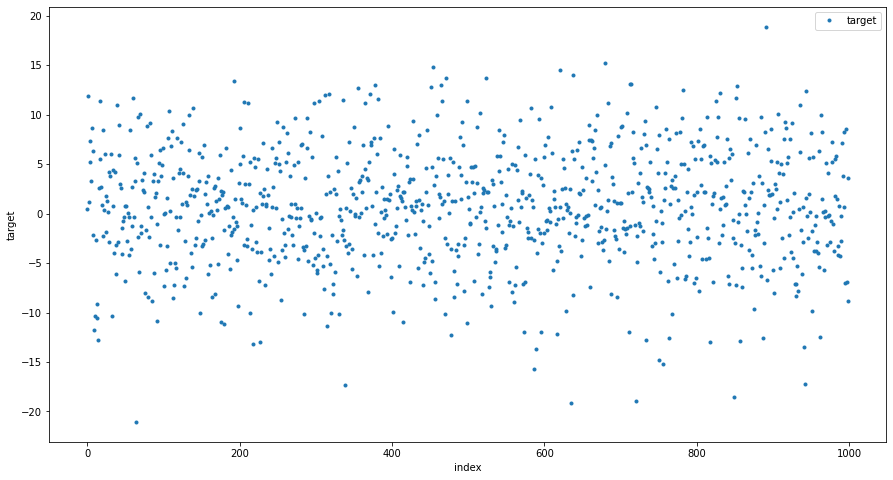

In [131]:
display(df_train.sample(10))
display(df_target.sample(10))

fig, ax = plt.subplots(1, 1)
figsize=(15, 8)
df_target.plot(style='.', figsize=figsize, ax=ax)
ax.set_xlabel('index')
ax.set_ylabel('target')

Text(0, 0.5, 'target')

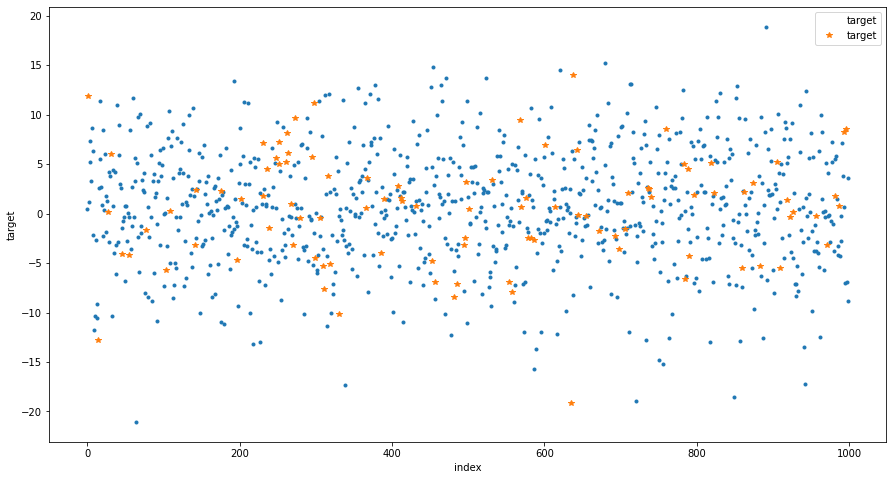

In [132]:
## Train/Test
X_train, X_test, Y_train, Y_test = train_test_split(df_train, df_target, test_size=0.1, random_state=0)

fig, ax = plt.subplots(1, 1)
figsize=(15, 8)
Y_train.plot(style='.', figsize=figsize, ax=ax)
Y_test.plot(style='*', figsize=figsize, ax=ax)
ax.set_xlabel('index')
ax.set_ylabel('target')

# 2. Preprocesamiento:  Feature scaling
* Remover la media (media=0) 
* Escalar la variance (var=1)

In [133]:
## Split training and test datasets.

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index)
X_test_scaled.columns = X_test.columns   

x_train, x_val, y_train, y_val = train_test_split(X_train_scaled, Y_train, test_size=0.2, random_state=0)


# 2. Model

## Approximated function: 

### $$\pmb{\hat{y}_i} = f(\pmb{x_i}, W) = \pmb{f^{h}}^T\pmb{w^{out}} \in R;~~\pmb{w^{out}}\in R^{d_h\times 1}$$
Donde
$$\pmb{f^1} = g(\pmb{x_i}^T\pmb{w^1}) \in R^{d_1};~~\pmb{w^1}\in R^{D\times d_1}$$
$$\pmb{f^2} = g(\pmb{f^1}^T\pmb{w^2}) \in R^{d_2};~~\pmb{w^2}\in R^{d1\times d_2}$$
$$~~~~...~~~~$$
$$\pmb{f^h} = g(\pmb{f^{h-1}}^T\pmb{w^h}) \in R^{d_h};~~\pmb{w^h}\in R^{d_{h-1}\times d_h}$$

$W = \{\pmb{w^1}, \pmb{w^2}, \pmb{w^3},...,\pmb{w^h}, \pmb{w^{out}}\}$; 

- $g(\bullet)$ is an activation function.   
- input layer: $f^1$
- output layer: $f$
- hidden layers: $f^2, f^3, ..., f^h$
- depth: number of hidden layers.

https://playground.tensorflow.org/

In [134]:
input_shape = 20
output_shape = 1
dict_parameters = {}
dict_parameters['units'] = 500
dict_parameters['dropout'] = 0.3
dict_parameters['hidden'] = 1
dict_parameters['rate_var_units'] = 0.9
dict_parameters['rate_var_drop'] = 0.9
dict_parameters['activation'] = 'relu'

In [135]:
## Read the model
model = define_ffnn_model(input_shape, output_shape, dict_parameters)
model.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_148 (Dense)           (None, 500)               10500     
                                                                 
 activation_111 (Activation)  (None, 500)              0         
                                                                 
 dropout_111 (Dropout)       (None, 500)               0         
                                                                 
 dense_149 (Dense)           (None, 1)                 500       
                                                                 
Total params: 11,000
Trainable params: 11,000
Non-trainable params: 0
_________________________________________________________________


# 3. Entrenamiento
## Loss function
## $$L(W) = \frac{1}{N}\sum_{i=1}^N (y_i - f(\pmb{x_i}, W))^2 \in R$$

## Encontrar $\hat{W}$ que minimize $L(\hat{W})$

# Optimization usando SGD

In [139]:
is_evaluation = False
batch_size = 128
num_epochs  = 300
learning_rate = 0.001

In [140]:
list_callbacks = []

train_ds = make_dataset(x_train.values,    
                        y_train.values,
                        batch_size=batch_size,
                        is_training=True)            

valid_ds = make_dataset(x_val.values,    
                        y_val.values,
                        batch_size=batch_size,
                        is_training=False)          

##Training
early_stop = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')   
list_callbacks.append(early_stop) 

### Optimization ###
# optimizer = tf.optimizers.Adam(dict_parameters['learning_rate'])
optimizer = tf.optimizers.SGD(learning_rate)
metrics = ['mse', "mae"]

model = define_ffnn_model(input_shape, output_shape, dict_parameters)

### model compile and fit ###
model.compile(optimizer=optimizer, loss='mse', metrics=metrics)    

Epoch 1/300
6/6 [==============================] - 0s 22ms/step - loss: 34.1151 - mse: 33.7344 - mae: 4.5406 - val_loss: 32.6116 - val_mse: 32.2310 - val_mae: 4.4628
Epoch 2/300
6/6 [==============================] - 0s 4ms/step - loss: 33.2429 - mse: 32.8622 - mae: 4.4723 - val_loss: 31.8785 - val_mse: 31.4978 - val_mae: 4.4118
Epoch 3/300
6/6 [==============================] - 0s 4ms/step - loss: 32.4511 - mse: 32.0704 - mae: 4.4184 - val_loss: 31.1545 - val_mse: 30.7737 - val_mae: 4.3606
Epoch 4/300
6/6 [==============================] - 0s 4ms/step - loss: 31.5493 - mse: 31.1684 - mae: 4.3593 - val_loss: 30.4373 - val_mse: 30.0562 - val_mae: 4.3093
Epoch 5/300
6/6 [==============================] - 0s 4ms/step - loss: 30.9061 - mse: 30.5250 - mae: 4.3112 - val_loss: 29.7241 - val_mse: 29.3428 - val_mae: 4.2577
Epoch 6/300
6/6 [==============================] - 0s 5ms/step - loss: 30.1160 - mse: 29.7345 - mae: 4.2577 - val_loss: 29.0207 - val_mse: 28.6390 - val_mae: 4.2060
Epoch 7/3

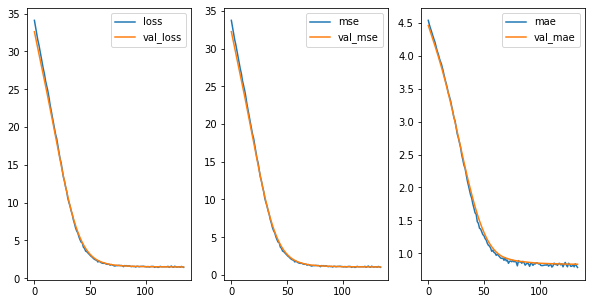

In [141]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, 
                    callbacks=list_callbacks)            

show_curves(history)


# 4 Evaluacion sobre Test

In [142]:
train_ds_tmp = make_dataset(X_train_scaled.values,    
                        Y_train.values,
                        batch_size=batch_size,
                        is_training=False)            

test_ds = make_dataset(X_test_scaled.values,    
                       Y_test.values,
                        batch_size=batch_size,
                        is_training=False)       

In [143]:
dict_metrics_train = compute_metrics(model, train_ds) 
dict_metrics_test = compute_metrics(model, test_ds) 

df_results = pd.DataFrame([dict_metrics_train, dict_metrics_test])
df_results.index = ['train', 'test']
df_results

,rmse,mae
train,0.849412,0.6822
test,0.983107,0.7658


In [144]:
y_train_tmp, y_train_pred_tmp = get_predictions(train_ds)
y_test_tmp, y_test_pred_tmp = get_predictions(test_ds)

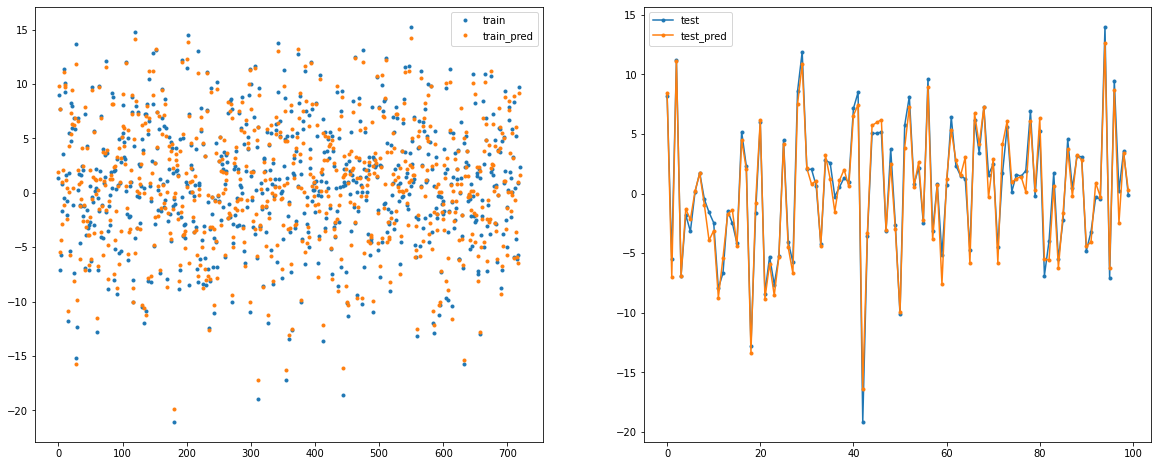

In [145]:
plot_results(y_train_tmp.reshape(-1), y_train_pred_tmp.reshape(-1), 
             y_test_tmp.reshape(-1), y_test_pred_tmp.reshape(-1))